# Roll decay test system identification


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit, minimize, basinhopping

from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from rolldecay.simulation import roll_decay_time_step,simulate
import rolldecay
import rolldecay.read_funky_ascii
import inspect

In [208]:
ascii_path = os.path.join(rolldecay.data_path,'project1','Ascii files','20084871056k.15.asc')
df = rolldecay.read_funky_ascii.read(ascii_path=ascii_path)
scale = 29.565
df.index*=np.sqrt(scale)  # To full scale

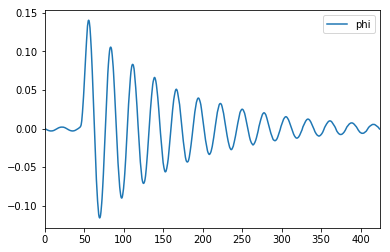

In [209]:
df.plot(y='phi')

In [210]:
index = df['phi'].abs().idxmax()
df_cut = df.loc[index:].copy()


In [211]:
from scipy import signal

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):

    if cutoff is None or order is None:
        # Disabled filter:
        return data

    b, a = butter_lowpass(cutoff, fs, order=order)
    #y = signal.lfilter(b, a, data)
    y = signal.filtfilt(b, a, data)

    return y

In [212]:
df_cut['phi_raw'] = df_cut['phi']

In [213]:
ts = np.mean(np.diff(df_cut.index))
fs = 1/ts


df_cut['phi'] = lowpass_filter(data=df_cut['phi_raw'], cutoff=0.1, fs=fs, order=5)


In [214]:
df_cut = df_cut.iloc[300:-300]

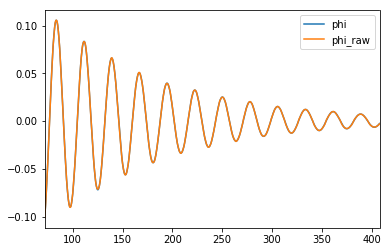

In [215]:
df_cut.plot(y=['phi','phi_raw'])

In [216]:
df_cut['phi1d'] = np.gradient(df_cut['phi'].values,df_cut.index.values)
df_cut['phi2d'] = np.gradient(df_cut['phi1d'].values,df_cut.index.values)

#t = df_cut.index.values
#dt = np.diff(t)
#phi = df_cut['phi'].values
#phi1d = np.diff(phi)/dt
#phi2d = phi1d/dt[0:]
#
#df_cut['phi1'] = df_cut['phi'].iloc[0:-1]
#df_cut['phi1d'] = phi1d[0:]
#df_cut['phi2d'] = phi2d



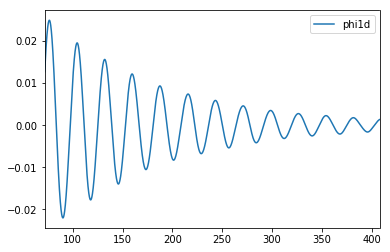

In [217]:
df_cut.plot(y='phi1d')

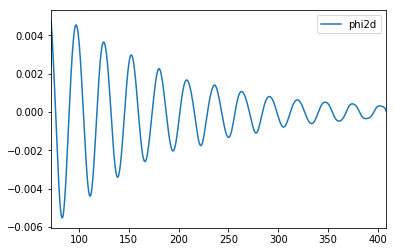

In [218]:
df_cut.plot(y='phi2d')

In [195]:
def f_direct(df, d, omega0, zeta):
    
    phi_old = df['phi']
    p_old = df['phi1d']
    
    phi2d = calculate_acceleration(d=d, omega0=omega0, p_old=p_old, phi_old=phi_old, zeta=zeta)
    return phi2d
    
def fit_direct(df, p0=None):
    
    popt,pcov = curve_fit(f=f_direct,xdata=df,ydata=df['phi2d'],p0=p0)
    signature = inspect.signature(f_direct)
    parameter_names = list(signature.parameters.keys())[1:]
    
    parameter_values = list(popt)
    parameters = dict(zip(parameter_names, parameter_values))
    
    return parameters,pcov


In [199]:
parameters_direct,pcov = fit_direct(df=df_cut)
parameters_direct

{'d': -0.18148534739695127,
 'omega0': 0.22628036609939473,
 'zeta': 0.0434122403680992}

In [200]:
parameters_report

{'d': 0.165, 'omega0': 0.2262580233049905, 'zeta': 0.0336}

Text(0.5, 1.0, 'Simulation with paramters from PIT')

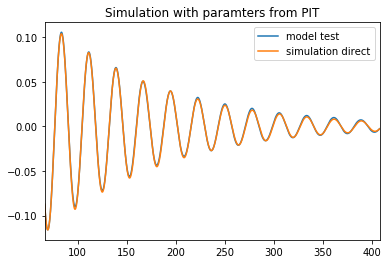

In [201]:
phi0 = df_cut['phi'].iloc[0]
phi1d0 = df_cut['phi1d'].iloc[0]
df_sim = simulate(t=df_cut.index, **parameters_direct, phi0=phi0, phi1d0=phi1d0)

fig,ax = plt.subplots()
df_cut.plot(y='phi', ax=ax, label='model test')
df_sim.plot(y='phi', ax=ax, label='simulation direct')
ax.set_title('Simulation with paramters from PIT')

In [202]:
def f(df, omega0, d, zeta):
    
    phi0 = df['phi'].iloc[0]
    phi1d0 = 0  # Rough assumption!
    
    t = df.index
    df_sim = simulate(t=t, phi0=phi0, phi1d0=phi1d0, omega0=omega0, d=d, zeta=zeta)
    return np.array(df_sim['phi'])

In [203]:
def fit(f,df,p0=None):
    
    ydata = df['phi']
    
    if p0 is None:
        p0 = [1,1,1]
    
    popt,pcov = curve_fit(f=f,xdata=df,ydata=ydata,p0=p0)
    
    signature = inspect.signature(f)
    parameter_names = list(signature.parameters.keys())[1:]
    
    parameter_values = list(popt)
    parameters = dict(zip(parameter_names, parameter_values))
    
    return parameters


In [204]:
T0_guess = 27
omega0_guess = 2*np.pi/T0_guess
d_guess = 0.16  # Qudratic damping
zeta_guess = 0.03  # Linear damping


parameters = fit(f=f, df=df_cut, p0=[omega0_guess,d_guess,zeta_guess])

In [205]:
parameters

{'d': 0.16112174718179667,
 'omega0': 0.23093040299909473,
 'zeta': 0.02991243785119438}

In [206]:
2*np.pi/parameters['omega0']

27.208133816854843

Text(0.5, 1.0, 'Simulation with paramters from PIT')

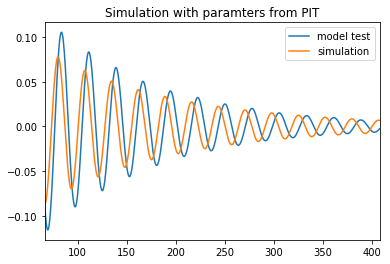

In [207]:
phi0 = df_cut['phi'].iloc[0]
phi1d0 = 0
df_sim = simulate(t=df_cut.index, **parameters, phi0=phi0, phi1d0=phi1d0)

fig,ax = plt.subplots()
df_cut.plot(y='phi', ax=ax, label='model test')
df_sim.plot(y='phi', ax=ax, label='simulation')
ax.set_title('Simulation with paramters from PIT')

Text(0.5, 1.0, 'Simulation with parameters from report')

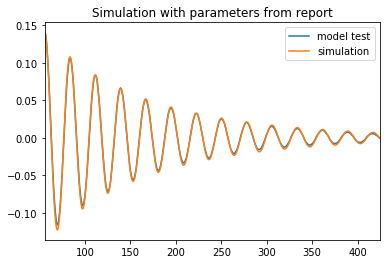

In [15]:
phi0 = df_cut['phi'].iloc[0]
phi1d0 = 0

parameters_report = {
    'd': 0.165,
    'omega0': 2*np.pi/27.77,
    'zeta': 0.0336,
}


df_sim = simulate(t=df_cut.index, **parameters_report, phi0=phi0, phi1d0=phi1d0)

fig,ax = plt.subplots()
df_cut.plot(y='phi', ax=ax, label='model test')
df_sim.plot(y='phi', ax=ax, label='simulation')
ax.set_title('Simulation with parameters from report')

Text(0.5, 1.0, 'Simulation with parameters from report')

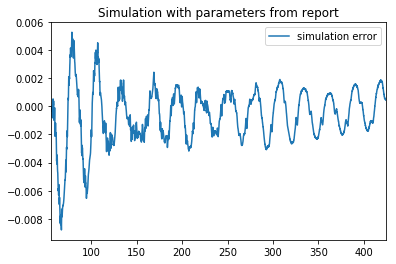

In [16]:
fig,ax = plt.subplots()
df_sim['phi_error'] = df_sim['phi'] - df_cut['phi']

df_sim.plot(y='phi_error', ax=ax, label='simulation error')
ax.set_title('Simulation with parameters from report')

Text(0.5, 1.0, 'Simulation with parameters from report')

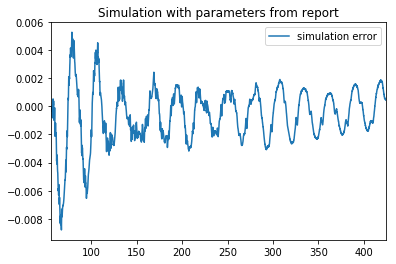

In [17]:
fig,ax = plt.subplots()
df_sim['phi_error'] = df_sim['phi'] - df_cut['phi']

df_sim.plot(y='phi_error', ax=ax, label='simulation error')
ax.set_title('Simulation with parameters from report')

In [33]:

def fit_optimize(df, p0=None):
    
    def error(x):
    
        omega0, d, zeta = x[0], x[1], x[2]
    
        phi_sim = f(df=df, omega0=omega0, d=d, zeta=zeta)
        
        phi = df['phi']
        phi_max = phi.abs().max()
        return (((phi_sim-phi)/phi_max)**2).mean()
    
    
    if p0 is None:
        p0 = [1,1,1]
        
    #return minimize(fun=error, x0=p0)
    return basinhopping(func=error, x0=p0)
    

In [34]:
T0_guess = 27
omega0_guess = 2*np.pi/T0_guess
d_guess = 0.16  # Qudratic damping
zeta_guess = 0.03  # Linear damping


parameters = fit_optimize(df=df_cut, p0=[omega0_guess,d_guess,zeta_guess])

c:\dev\rolldecay\venv\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [35]:
parameters

                        fun: 0.0004948264110469663
 lowest_optimization_result:       fun: 0.0004948264110469663
 hess_inv: array([[ 3.28698006e-09, -4.07850741e-08,  5.48669176e-10],
       [-4.07850741e-08,  5.08497985e-07, -7.26986060e-09],
       [ 5.48669176e-10, -7.26986060e-09,  1.79717262e-10]])
      jac: array([-0.0987386 ,  0.02457288,  0.19587227])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 656
      nit: 5
     njev: 129
   status: 2
  success: False
        x: array([0.22606936, 0.15995899, 0.04025358])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 101
                       nfev: 40746
                        nit: 100
                       njev: 7928
                          x: array([0.22606936, 0.15995899, 0.04025358])

In [42]:
parameters_optimize = {
    'omega0':parameters.x[0],
    'd':parameters.x[1],
    'zeta':parameters.x[2],
    
}
parameters_optimize

{'d': 0.15995899468417663,
 'omega0': 0.22606936416293558,
 'zeta': 0.04025357737092497}

In [43]:
parameters_report

{'d': 0.165, 'omega0': 0.2262580233049905, 'zeta': 0.0336}

Text(0.5, 1.0, 'Simulation with parameters from report')

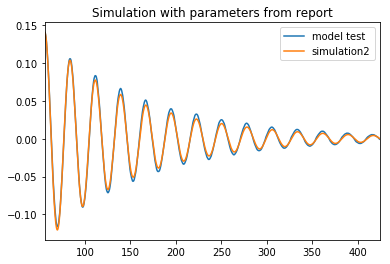

In [44]:
df_sim2 = simulate(t=df_cut.index, **parameters_optimize, phi0=phi0, phi1d0=phi1d0)

fig,ax = plt.subplots()
df_cut.plot(y='phi', ax=ax, label='model test')
df_sim2.plot(y='phi', ax=ax, label='simulation2')
ax.set_title('Simulation with parameters from report')